# Linear Buckling of a Metal Panel
TODO : add either relu kernel zero at boundary
and/or add kernels of different length scales.
Also could try Matern kernel or other kernels that can mix different length scales.
For buckling could try some type of sine kernel?

In [12]:
# panel linear buckling
# buckling inputs
# ----------------

# aluminum plate material properties
E = 70e9; nu = 0.3; thick = 0.005
D = E * thick**3 / 12.0 / (1 - nu**2)
(a, b) = (3, 1)
# (a, b) = (1,1)

# choose kernel hyperparameters
# Lx, Ly = (0.5, 0.4)
Lx, Ly = (0.2, 0.2)
eta = 1e-7
afrac = 0.5
# eta = 1e-5

# num_domain, num_bndry, num_test = (10, 5, 5)
# num_domain, num_bndry, num_test = (500, 200, 50)
# num_domain, num_bndry, num_test = (3000, 600, 50)
num_domain, num_bndry, num_test = (1000, 800, 50)

In [13]:
# buckling inputs

axial = True
if axial:
    Nxx, Nxy, Nyy = (1e3, 0, 0)
else:
    Nxx, Nxy, Nyy = (0, 1e2, 0)

# predict the buckling load factor (BLF)
pi = 3.14159
if axial:
    pred_buckling_load = pi**2 * D / b**2 * 4.0 
    pred_load_factor = pred_buckling_load / Nxx
    sigma = 0.5 * pred_load_factor
    print(f"{pred_load_factor=}")

# corrected prediction from FEA
# lam[i]=(16.1634202010277+0j)
# pred_load_factor = 16.163432

pred_load_factor=31.633294000320518


type(x_train)=<class 'tensorflow.python.ops.resource_variable_ops.ResourceVariable'>


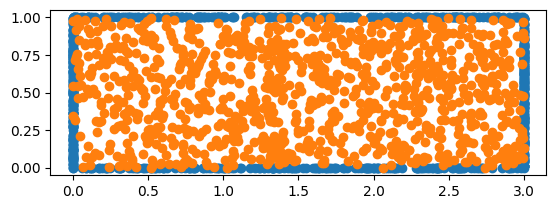

In [14]:
# compute the linear static analysis inputs and mesh domain of collocation pts
# ----------------------------------------------------------------------------
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

num_interior = num_domain
DTYPE = tf.float32

# set the boundary of the panel
xmin = 0; xmax = a
ymin = 0; ymax = b

lb = tf.constant([xmin, ymin], dtype=DTYPE)
ub = tf.constant([xmax, ymax], dtype=DTYPE)

# generate the collocation points on the interior
def gen_collocation_points(num_domain, minval, maxval):
    x_r = tf.random.uniform((num_domain,1), minval[0], maxval[0], dtype=DTYPE)
    y_r = tf.random.uniform((num_domain,1), minval[1], maxval[1], dtype=DTYPE)
    X_r = tf.concat([x_r, y_r], axis=1)
    # data_init = tf.random_uniform_initializer(minval=minval, maxval=maxval, seed=0)
    # return tf.Variable(data_init(shape=[num_domain, 1]), dtype=tf.float32)
    return tf.Variable(X_r, dtype=DTYPE)

x_train = gen_collocation_points(num_domain, lb, ub)
x_test = gen_collocation_points(num_test, lb, ub)
print(f"{type(x_train)=}")

x = x_train[:,0:1]
y = x_train[:,1:2]

x2 = x_test[:,0:1]
y2 = x_test[:,1:2]

# generate boundary domain points
assert num_bndry % 2 == 0
N_b = int(num_bndry / 2)
x_b1 = tf.random.uniform((N_b,1), lb[0], ub[0], dtype=DTYPE)
y_b1 = lb[1] + (ub[1] - lb[1]) * \
    tf.keras.backend.random_bernoulli((N_b,1), 0.5, dtype=DTYPE)
X_b1 = tf.concat([x_b1, y_b1], axis=1)

# boundary data on x edges
y_b2 = tf.random.uniform((N_b,1), lb[1], ub[1], dtype=DTYPE)
x_b2 = lb[0] + (ub[0] - lb[0]) * \
    tf.keras.backend.random_bernoulli((N_b,1), 0.5, dtype=DTYPE)
# print(f"{x_b2=}")
X_b2 = tf.concat([x_b2, y_b2], axis=1)
# print(f"{X_b2=}")
# print(f"{x_b2=}")

x_bndry = tf.Variable(tf.concat([X_b1, X_b2], axis=0), dtype=DTYPE)

# plot the data to check
plt.scatter(x_bndry[:,0], x_bndry[:,1])
plt.scatter(x_train[:,0], x_train[:,1]) # only show 1000 of the points
plt.gca().set_aspect('equal')
plt.show()

In [15]:
# find the x_train point nearest the center and sort it so that one is first
# or change first point to the midpoint
x_train = x_train.numpy()
x_train[0,0] = a*afrac # near middle but not exactly
x_train[0,1] = b/2

In [16]:
# define vectorized versions of the kernel functions
# like 1000x faster at assembling covariance functions

L_tf = tf.constant(np.array([Lx, Ly]), dtype=DTYPE)
def SE_kernel2d_tf(x, xp, Lvec):
    # x input is N x 1 x 2 array, xp is 1 x M x 2 array
    # xbar is then an N x M x 2 shape array
    # print(f"{x=} {L_tf=}")
    xbar = (x - xp) / Lvec
    # output is N x M matrix of kernel matrix
    return tf.exp(-0.5 * tf.reduce_sum(tf.pow(xbar, 2.0), axis=-1))

def kernel2d_tf(x, xp):
    """composite kernel definition"""
    return SE_kernel2d_tf(x, xp, L_tf)

def d2_fact(xbar, L):
    return L**(-2.0) * (-1.0 + xbar**2)

def d4_fact(xbar,L):
    return L**(-4.0) * (3.0 - 6.0 * xbar**2 + xbar**4)

def d6_fact(xbar,L):
    return L**(-6.0) * (-15 + 45 * xbar**2 - 15 * xbar**4 + xbar**6)

def d8_fact(xbar,L):
    return L**(-8.0) * (105 - 420 * xbar**2 + 210 * xbar**4 - 28 * xbar**6 + xbar**8)

def SE_kernel2d_bilapl_tf(x, xp, Lvec):
    # first two dimensions are NxN matrix parts
    # x is N x 1 x 2 matrix, xp is 1 x M x 2 matrix
    xbar = (x - xp) / Lvec # N x M x 2 matrix
    x1bar = xbar[:,:,0]
    x2bar = xbar[:,:,1]
    Lx = Lvec[0]; Ly = Lvec[1]

    # baseline kernel matrix which we will scale and add some terms
    K = kernel2d_tf(x,xp)

    return K * (d4_fact(x1bar,Lx) + 2.0 * d2_fact(x1bar, Lx) * d2_fact(x2bar, Ly) + d4_fact(x2bar, Ly))

def kernel2d_bilapl_tf(x, xp):
    """composite kernel definition"""
    return SE_kernel2d_bilapl_tf(x, xp, L_tf)

def SE_kernel2d_double_bilapl_tf(x, xp, Lvec):
    # first two dimensions are NxN matrix parts
    # x is N x 1 x 2 matrix, xp is 1 x M x 2 matrix
    xbar = (x - xp) / Lvec # N x M x 2 matrix
    x1bar = xbar[:,:,0]
    x2bar = xbar[:,:,1]
    Lx = Lvec[0]; Ly = Lvec[1]

    # baseline kernel matrix which we will scale and add some terms
    K = kernel2d_tf(x,xp)

    return K * (d8_fact(x1bar,Lx) + \
                4.0 * d6_fact(x1bar, Lx) * d2_fact(x2bar, Ly) +\
                6.0 * d4_fact(x1bar, Lx) * d4_fact(x2bar, Ly) +\
                4.0 * d2_fact(x1bar, Lx) * d6_fact(x2bar, Ly) +\
                d8_fact(x2bar, Ly))

def kernel2d_double_bilapl_tf(x, xp):
    """composite kernel definition"""
    return SE_kernel2d_double_bilapl_tf(x, xp, L_tf)

# moment kernels
def dx2_kernel_tf(x, xp):
    # first two dimensions are NxN matrix parts
    # x is N x 1 x 2 matrix, xp is 1 x M x 2 matrix
    xbar = (x - xp) / L_tf # N x M x 2 matrix
    x1bar = xbar[:,:,0]
    x2bar = xbar[:,:,1]
    Lx = L_tf[0]; Ly = L_tf[1]

    # baseline kernel matrix which we will scale and add some terms
    K = kernel2d_tf(x,xp)

    # TODO : shear or general case later (just axial now)
    return K * (d2_fact(x1bar, Lx))

def dy2_kernel_tf(x, xp):
    # first two dimensions are NxN matrix parts
    # x is N x 1 x 2 matrix, xp is 1 x M x 2 matrix
    xbar = (x - xp) / L_tf # N x M x 2 matrix
    x1bar = xbar[:,:,0]
    x2bar = xbar[:,:,1]
    Lx = L_tf[0]; Ly = L_tf[1]

    # baseline kernel matrix which we will scale and add some terms
    K = kernel2d_tf(x,xp)
    return K * (d2_fact(x2bar, Ly))

def doubledx2_kernel_tf(x, xp):
    # first two dimensions are NxN matrix parts
    # x is N x 1 x 2 matrix, xp is 1 x M x 2 matrix
    xbar = (x - xp) / L_tf # N x M x 2 matrix
    x1bar = xbar[:,:,0]
    x2bar = xbar[:,:,1]
    Lx = L_tf[0]; Ly = L_tf[1]

    # baseline kernel matrix which we will scale and add some terms
    K = kernel2d_tf(x,xp)

    # TODO : shear or general case later (just axial now)
    return K * (d4_fact(x1bar, Lx))

def doubledy2_kernel_tf(x, xp):
    # first two dimensions are NxN matrix parts
    # x is N x 1 x 2 matrix, xp is 1 x M x 2 matrix
    xbar = (x - xp) / L_tf # N x M x 2 matrix
    x1bar = xbar[:,:,0]
    x2bar = xbar[:,:,1]
    Lx = L_tf[0]; Ly = L_tf[1]

    # baseline kernel matrix which we will scale and add some terms
    K = kernel2d_tf(x,xp)
    return K * (d4_fact(x2bar, Ly))

def dx2_bilapl_kernel_tf(x, xp):
    # first two dimensions are NxN matrix parts
    # x is N x 1 x 2 matrix, xp is 1 x M x 2 matrix
    xbar = (x - xp) / L_tf # N x M x 2 matrix
    x1bar = xbar[:,:,0]
    x2bar = xbar[:,:,1]
    Lx = L_tf[0]; Ly = L_tf[1]

    # baseline kernel matrix which we will scale and add some terms
    K = kernel2d_tf(x,xp)

    # TODO : shear or general case later (just axial now)
    return K * \
        (d6_fact(x1bar,Lx) + 2.0 * d4_fact(x1bar, Lx) * d2_fact(x2bar, Ly) + d2_fact(x1bar, Lx) * d4_fact(x2bar, Ly))

def dy2_bilapl_kernel_tf(x, xp):
    # first two dimensions are NxN matrix parts
    # x is N x 1 x 2 matrix, xp is 1 x M x 2 matrix
    xbar = (x - xp) / L_tf # N x M x 2 matrix
    x1bar = xbar[:,:,0]
    x2bar = xbar[:,:,1]
    Lx = L_tf[0]; Ly = L_tf[1]

    # baseline kernel matrix which we will scale and add some terms
    K = kernel2d_tf(x,xp)
    return K * \
        (d4_fact(x1bar,Lx) * d2_fact(x2bar, Ly) + 2.0 * d2_fact(x1bar, Lx) * d4_fact(x2bar, Ly) + d6_fact(x2bar, Ly))

def dx2_dy2_kernel_tf(x, xp):
    # first two dimensions are NxN matrix parts
    # x is N x 1 x 2 matrix, xp is 1 x M x 2 matrix
    xbar = (x - xp) / L_tf # N x M x 2 matrix
    x1bar = xbar[:,:,0]
    x2bar = xbar[:,:,1]
    Lx = L_tf[0]; Ly = L_tf[1]

    # baseline kernel matrix which we will scale and add some terms
    K = kernel2d_tf(x,xp)
    return K * d2_fact(x1bar, Lx) * d2_fact(x2bar, Ly)

num_interior=1000 num_all=1800
done with eigenvalues solve


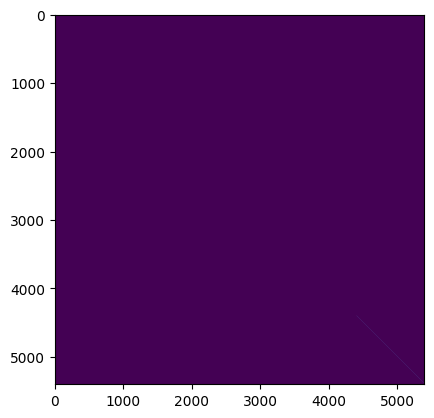

In [17]:
# compute the block matrix Sigma = [cov(w_int, w_int), cov(w_int, w_bndry), cov(w_int, nabla^4 w_int),
#                                   cov(w_bndry, w_int), cov(w_bndry, w_bndry), cov(w_bndry, nabla^4 w_bndry),
#                                   cov(nabla^4 w_int, w_int), cov(nabla^4 w_int, w_bndry), cov(nabla^4 w_int, nabla^4 w_int) ]
# not a function of theta..
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

n_block = 3 * num_interior + 3 * num_bndry
x_all = tf.concat([x_train, x_bndry], axis=0)
num_all = num_interior + num_bndry

# components of the multivariate GP
# 1 - w at interior and bndry points
# 2 - d^2w/dx^2 at bndry points
# 3 - d^2w/dy^2 at bndry points
# 4 - nabla^4 w at interior points

# 11 - interior+bndry self-covariance
x_all_L = tf.expand_dims(x_all, axis=1)
x_all_R = tf.expand_dims(x_all, axis=0)
K11 = tf.constant(kernel2d_tf(x_all_L, x_all_R), dtype=DTYPE)

x_interior_L = tf.expand_dims(x_train, axis=1)
x_interior_R = tf.expand_dims(x_train, axis=0)
x_bndry_L = tf.expand_dims(x_bndry, axis=1)
x_bndry_R = tf.expand_dims(x_bndry, axis=0)

# 12 - w with dx2
K12 = tf.constant(dx2_kernel_tf(x_all_L, x_all_R))
# 13 - w with dy2
K13 = tf.constant(dy2_kernel_tf(x_all_L, x_bndry_R))
# 14 - w with nabla^4 w
K14 = tf.constant(kernel2d_bilapl_tf(x_all_L, x_interior_R))
# 22 - dx2 with dx2
K22 = tf.constant(doubledx2_kernel_tf(x_all_L, x_all_R))
# 23 - dx2 with dy2
K23 = tf.constant(dx2_dy2_kernel_tf(x_all_L, x_bndry_R))
# 24 - dx2 with nabla^4 w
K24 = tf.constant(dx2_bilapl_kernel_tf(x_all_L, x_interior_R))
# 33 - dy2 with dy2
K33 = tf.constant(doubledy2_kernel_tf(x_bndry_L, x_bndry_R))
# 34 - dy2 with nabla^4 w
K34 = tf.constant(dy2_bilapl_kernel_tf(x_bndry_L, x_interior_R))
# 44 - nabla^4 w with itself
K44 = tf.constant(kernel2d_double_bilapl_tf(x_interior_L, x_interior_R))

print(f"{num_interior=} {num_all=}")
# print(f"{K11.shape=} {K12.shape=} {K22.shape=}")
# print(f"{K13.shape=} {K23.shape=} {K33.shape=}")

# assemble full covariance matrix
_row1 = tf.constant(tf.concat([K11, K12, K13, K14], axis=1))
_row2 = tf.constant(tf.concat([tf.transpose(K12), K22, K23, K24], axis=1))
_row3 = tf.constant(tf.concat([tf.transpose(K13), tf.transpose(K23), K33, K34], axis=1))
_row4 = tf.constant(tf.concat([tf.transpose(K14), tf.transpose(K24), tf.transpose(K34), K44], axis=1))
Kblock_prereg = tf.concat([_row1, _row2, _row3, _row4], axis=0)

# from paper on this by Chen, need to use adaptive nugget term with trace ratio
tr11 = tf.linalg.trace(K11)
tr22 = tf.linalg.trace(K22)
tr33 = tf.linalg.trace(K33)
tr44 = tf.linalg.trace(K44)
diagonal = tf.concat([tf.ones((num_all,)), tr22 / tr11 * tf.ones((num_all,)), \
                      tr33 / tr11 * tf.ones((num_bndry,)), \
                      tr44 / tr11 * tf.ones((num_interior,))], axis=0)
regularization = eta * tf.linalg.diag(diagonal)
plt.imshow(regularization)

print("done with eigenvalues solve")

Kblock = tf.constant(Kblock_prereg + regularization, dtype=DTYPE)

# # show the matrix image to see if positive definite roughly
# plt.imshow(Kblock)
# plt.colorbar()

In [18]:
Kblock = Kblock.numpy()

In [19]:
# newton's algorithm
# ------------------
theta = np.zeros((2*num_interior-1,1))

# non-zero init
# theta[2] = 1.0
w0 = np.ones((1,1)) * 1.0e-2 # at 1st point (arbitrary)

eye_int = np.eye(num_interior)
eye_bndry = np.eye(num_bndry)
zero_cross = np.zeros((num_interior, num_bndry))
zero_int = np.zeros((num_interior,1))
zero_int_mat = np.zeros((num_interior, num_interior))
zero_bndry = np.zeros((num_bndry,1))
zscale = 1e4
lam = pred_load_factor # proposed eigenvalue, could tune this as part of theta later also

# c : regularization constant for term c * (|th|-1)^2
# c = 1e0

for inewton in range(2):
    # theta1 - w(Omega), theta2 - dx2 w(Omega)
    theta1 = theta[:num_interior-1,:]; theta2 = theta[num_interior-1:,:]

    # matrix is dimensions num_interior x num_block
    dzdth = np.concatenate([
        np.concatenate([eye_int, zero_cross, zero_int_mat, zero_cross, zero_cross, zero_int_mat], axis=1),
        np.concatenate([zero_int_mat, zero_cross, eye_int, zero_cross, zero_cross, -lam*Nxx/D * eye_int], axis=1),
    ], axis=0) * zscale

    # modify the matrix to have 1 fewer row (first row eliminated and 1st column is zero for constrained theta value)
    dzdth = dzdth[1:,:]
    dzdth[:,0] = 0.0

    # print(f"{Kblock.shape=}")
    # print(f"{dzdth.shape=}")
    
    # get actual value of z as in nMAP = z^T * Cov^-1 * z
    z = np.concatenate([
        w0, theta1, zero_bndry, theta2, zero_bndry, zero_bndry, -lam * Nxx / D * theta2
    ], axis=0) * zscale
    # print(f"{z=}")

    # H * dth = -grad is newton update
    temp = np.linalg.solve(Kblock, dzdth.T)
    H = 2 * dzdth @ temp

    temp2 = np.linalg.solve(Kblock, z)
    grad = 2 * dzdth @ temp2

    # regularization corrections
    # th_norm = np.linalg.norm(theta) + 1e-16
    # c2 = 2.0 * c * (1 - 1.0 / th_norm)
    # H += c2 * np.eye(2*num_interior)
    # grad += c2 * theta

    # newton update
    dtheta = -np.linalg.solve(H, grad)
    # print(f"{dtheta.shape=} {theta.shape=}")
    # theta.assign(theta + dtheta)
    alpha = 1.0
    theta = theta + alpha * dtheta

    # new objective cost
    # new objective cost
    newz = np.concatenate([
        w0, theta1, zero_bndry, theta2, zero_bndry, zero_bndry, -lam * Nxx / D * theta2
    ], axis=0) * zscale
    temp3 = np.linalg.solve(Kblock, newz)
    loss = newz.T @ temp3
    print(f"{inewton=} {loss=}")

inewton=0 loss=array([[-2.99949476e+10]])
inewton=1 loss=array([[116311.70215868]])


In [20]:
# predict the values at a grid of points (a mesh) so we can view predicted contour of the solution
# using the mean interpolated from trained values
import numpy as np

w_full = newz / zscale

n = 100
ngrid = n * n
_xgrid = np.linspace(0.0, a, n)
_ygrid = np.linspace(0.0, b, n)
Xgrid, Ygrid = np.meshgrid(_xgrid, _ygrid)
print(f"{Xgrid.shape=}")
xgrid = np.reshape(Xgrid, newshape=(ngrid,1))
ygrid = np.reshape(Ygrid, newshape=(ngrid,1))
x_grid = np.concatenate([xgrid, ygrid], axis=1)

# old non-vectorized way
# K_train = np.array([[kernel2d(x_all[i,:], x_all[j,:]) for j in range(num_all)] for i in range(num_all)])
# K_cross = np.array([[kernel2d(x_grid[i,:], x_all[j,:]) for j in range(num_all)] for i in range(ngrid)])

# vectorized way like 100x faster
K_train = kernel2d_tf(x_all_L, x_all_R)
x_grid_L = tf.expand_dims(tf.constant(x_grid, dtype=DTYPE), axis=1)
K_cross = kernel2d_tf(x_grid_L, x_all_R)

max_eigval = np.max(np.linalg.eigvalsh(K_train))
W_grid = tf.linalg.matmul(K_cross, np.linalg.solve(K_train + 1e-5 * max_eigval * np.eye(num_all), w_full[:num_all,:]))
W = np.reshape(W_grid, newshape=(n, n))

Xgrid.shape=(100, 100)


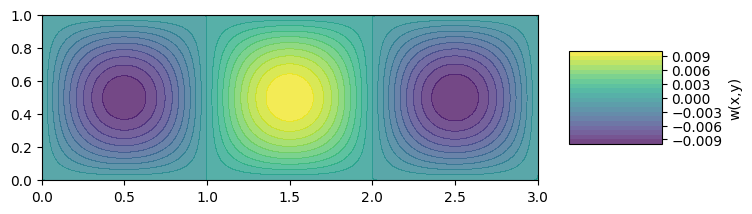

In [21]:
import matplotlib.pyplot as plt
# now plot the predicted solution contour
plt.figure(figsize=(8, 6))
colors = plt.contourf(Xgrid, Ygrid, W, levels=20, cmap='viridis', alpha=0.75)  # Filled contours
plt.gca().set_aspect('equal')
plt.colorbar(colors, label="w(x,y)", shrink=0.5, aspect=1)  # Colorbar for reference

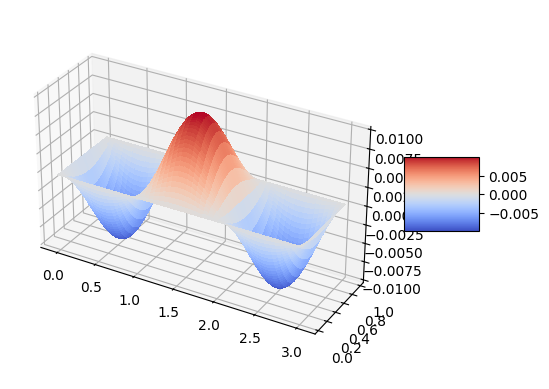

In [22]:
import matplotlib.pyplot as plt
from matplotlib import cm
# now plot the predicted solution surface in 3d
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
surf = ax.plot_surface(Xgrid, Ygrid, W, cmap=cm.coolwarm, linewidth=0, antialiased=False)
fig.colorbar(surf, shrink=0.5, aspect=1)
ax.set_aspect('equalxy')
plt.show()